In [1]:
import geopandas as gpd
import pandas as pd
import rasterio
from rasterstats import zonal_stats
import odc.geo.xr
import numpy as np

import xarray as xr
import dask
import dask.array as da
from dask.diagnostics import ProgressBar
from dask.distributed import Client

from glob import glob
import os

from pathlib import Path

import sys
sys.path.append('/home/548/cd3022/aus-historical-solar-droughts/code/python/scripts')
import utils

In [2]:
shapefile = '/home/548/cd3022/aus-historical-solar-droughts/data/boundary_files/REZ-boundaries.shx'
gdf = gpd.read_file(shapefile)

In [3]:
ncpus = os.environ.get('PBS_NCPUS')
client = Client(n_workers=int(ncpus))
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 24
Total threads: 24,Total memory: 95.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34801,Workers: 24
Dashboard: /proxy/8787/status,Total threads: 24
Started: Just now,Total memory: 95.00 GiB
Comm: tcp://127.0.0.1:35797,Total threads: 1
Dashboard: /proxy/35029/status,Memory: 3.96 GiB
Nanny: tcp://127.0.0.1:45783,


In [4]:
import logging
logging.getLogger('distributed').setLevel(logging.ERROR)

# Set up region to analyse

In [5]:
zones_to_ignore = [ # only wind farms in zone, no solar
    'Q1',
    'N7',
    'N8',
    'N10',
    'N11',
    'V3',
    'V4',
    'V7',
    'V8',
    'T4',
    'S1',
    'S3',
    'S4',
    'S5',
    'S10'
]

gdf = gdf[~gdf["Name"].str[:2].isin(zones_to_ignore)]

QLD = gdf[gdf["Name"].str.startswith("V")]

In [6]:
lon_min, lat_min, lon_max, lat_max = QLD.total_bounds

# Prepare Data

In [7]:
%%time
directory=Path('/g/data/rv74/satellite-products/arc/der/himawari-ahi/solar/p1s/latest/2020/07/01')
files = list(directory.rglob("*.nc"))
def _preprocess(ds):
    return ds[
    ['surface_global_irradiance', 'direct_normal_irradiance', 'surface_diffuse_irradiance']
    ].sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
ds = xr.open_mfdataset(files, parallel=True, preprocess=_preprocess)
ds = ds.chunk({'time':'auto', 'latitude':-1, 'longitude':-1})

CPU times: user 2.76 s, sys: 845 ms, total: 3.6 s
Wall time: 14.6 s


In [8]:
mask = rasterio.features.geometry_mask(
            QLD.geometry,
            out_shape=ds.odc.geobox.shape,
            transform=ds.odc.geobox.affine,
            all_touched=False,
            invert=False)
mask = xr.DataArray(~mask, dims=('latitude', 'longitude'),coords=dict(
        longitude=ds.longitude,
        latitude=ds.latitude))

In [9]:
masked_ds = ds.where(mask, drop=True)

In [10]:
masked_ds.chunks

Frozen({'time': (103,), 'latitude': (200,), 'longitude': (294,)})

# Function to compute pv gen

In [11]:
def rad_to_pv(ds):
    ghi = ds.surface_global_irradiance.data
    dni = ds.direct_normal_irradiance.data
    dhi = ds.surface_diffuse_irradiance.data
    nan_mask = da.isnan(ghi)
    nan_mask_flat = nan_mask.ravel()
    
    # Apply mask lazily with Dask
    ghi_clean = da.compress(~nan_mask_flat, ghi, axis=None)
    dni_clean = da.compress(~nan_mask_flat, dni, axis=None)
    dhi_clean = da.compress(~nan_mask_flat, dhi, axis=None)

    # get correct time and coordinate data, so that it matches up with the remaining irradiance values
    lat_1d = ds.latitude.data
    lon_1d = ds.longitude.data
    lon_grid, lat_grid = np.meshgrid(lon_1d, lat_1d, indexing="xy")

    lat_grid_1d = lat_grid.ravel()
    lon_grid_1d = lon_grid.ravel()

    lat_1d_expanded = da.tile(lat_grid_1d, ds.sizes["time"])
    lon_1d_expanded = da.tile(lon_grid_1d, ds.sizes["time"])
    time_1d = da.repeat(da.from_array(ds.time.data, chunks="auto"), len(lat_grid_1d))

    lat_1d_expanded_clean = da.compress(~nan_mask_flat, lat_1d_expanded, axis=None)
    lon_1d_expanded_clean = da.compress(~nan_mask_flat, lon_1d_expanded, axis=None)
    time_1d_clean = da.compress(~nan_mask_flat, time_1d, axis=None)

    # Now trigger computation only at the end
    # ghi_clean, dni_clean, dhi_clean, lat_1d_expanded_clean, lon_1d_expanded_clean, time_1d_clean = da.compute(
    #     ghi_clean, dni_clean, dhi_clean, lat_1d_expanded_clean, lon_1d_expanded_clean, time_1d_clean
    # )

    # calculate capacity factors using pvlib
    # the function defined in utils_V2 is essentially the same as the workflow in pv-output-tilting.ipynb
    actual_ideal_ratio = utils.tilting_panel_pr(
        pv_model = 'Canadian_Solar_CS5P_220M___2009_',
        inverter_model = 'ABB__MICRO_0_25_I_OUTD_US_208__208V_',
        ghi=ghi_clean,
        dni=dni_clean,
        dhi=dhi_clean,
        time=time_1d_clean,
        lat=lat_1d_expanded_clean,
        lon=lon_1d_expanded_clean
    )
    
    # nan_mask_flat_np = nan_mask_flat.compute()  # now a NumPy boolean array
    
    # 2. Create a full flattened output array, filling with NaN (or another default value)
    result_flat = np.full(ghi.size, np.nan)
    
    # 3. Insert the processed values into the correct positions.
    result_flat[~nan_mask_flat] = actual_ideal_ratio
    
    # 4. Reshape the flat array back into the original shape.
    result = result_flat.reshape(ghi.shape)
    ratio_da = xr.DataArray(result, coords=ds.coords, dims=ds.dims)
    
    return ratio_da

# Run analysis

In [12]:
solar_performance = xr.map_blocks(rad_to_pv, masked_ds)

In [13]:
compute_performance = solar_performance.compute()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 37.89 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 56.89 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 56.89 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 56.89 MiB.
This may cause some slowd

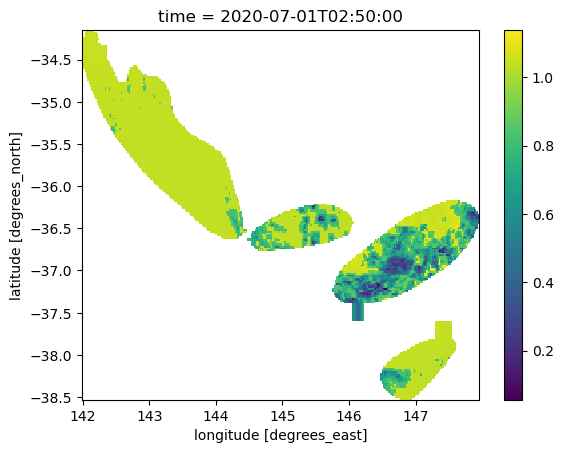

In [14]:
compute_performance.isel(time=50).plot()